<a href="https://colab.research.google.com/github/kon-si/ntua_img_vid_analysis/blob/master/anal_eik_vid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libraries**

In [73]:
import numpy as np
from skimage import data
from matplotlib import pyplot as plt
import math

**IPad**\
Για τον υπολογισμό των οριακών τιμών, προστίθεται στην αρχική εικόνα padding σύμφωνα με την μέθοδο **reflect**. Δηλαδή, η τελευταία σειρά του πίνακα επαναλαμβάνεται δύο φορές πάνω, κάτω, δεξιά και αριστερά αντίστοιχα.

In [74]:
def IPad(I):
  padded_I = np.zeros((I.shape[0]+4, I.shape[1]+4)) if I.ndim == 2 else np.zeros((I.shape[0]+4, I.shape[1]+4, 3))
  padded_I[2:padded_I.shape[0]-2, 2:padded_I.shape[1]-2] = I
  padded_I[0, 1:I.shape[1]+1], padded_I[1, 1:I.shape[1]+1] = I[0], I[0]
  padded_I[I.shape[0], 1:I.shape[1]+1], padded_I[I.shape[0]+1, 1:I.shape[1]+1] = I[I.shape[0]-1], I[I.shape[0]-1]
  padded_I[1:I.shape[0]+1, 0], padded_I[1:I.shape[0]+1, 1] = I[0:I.shape[0], 0], I[0:I.shape[0], 0]
  padded_I[1:I.shape[0]+1, I.shape[1]], padded_I[1:I.shape[0]+1, I.shape[1]+1] = I[0:I.shape[0], I.shape[1]-1], I[0:I.shape[0], I.shape[1]-1]
  return padded_I

**GKernel**

In [75]:
def GKernel(a):
  w_cup = np.array([1/4-a/2,1/4,a,1/4,1/4-a/2])
  h = np.zeros((5,5))
  for i in range(5):
    for j in range(5):
      h[i][j] = w_cup[i]*w_cup[j]
  return h

**GREDUCE**

Text(0.5, 1.0, 'Rocket')

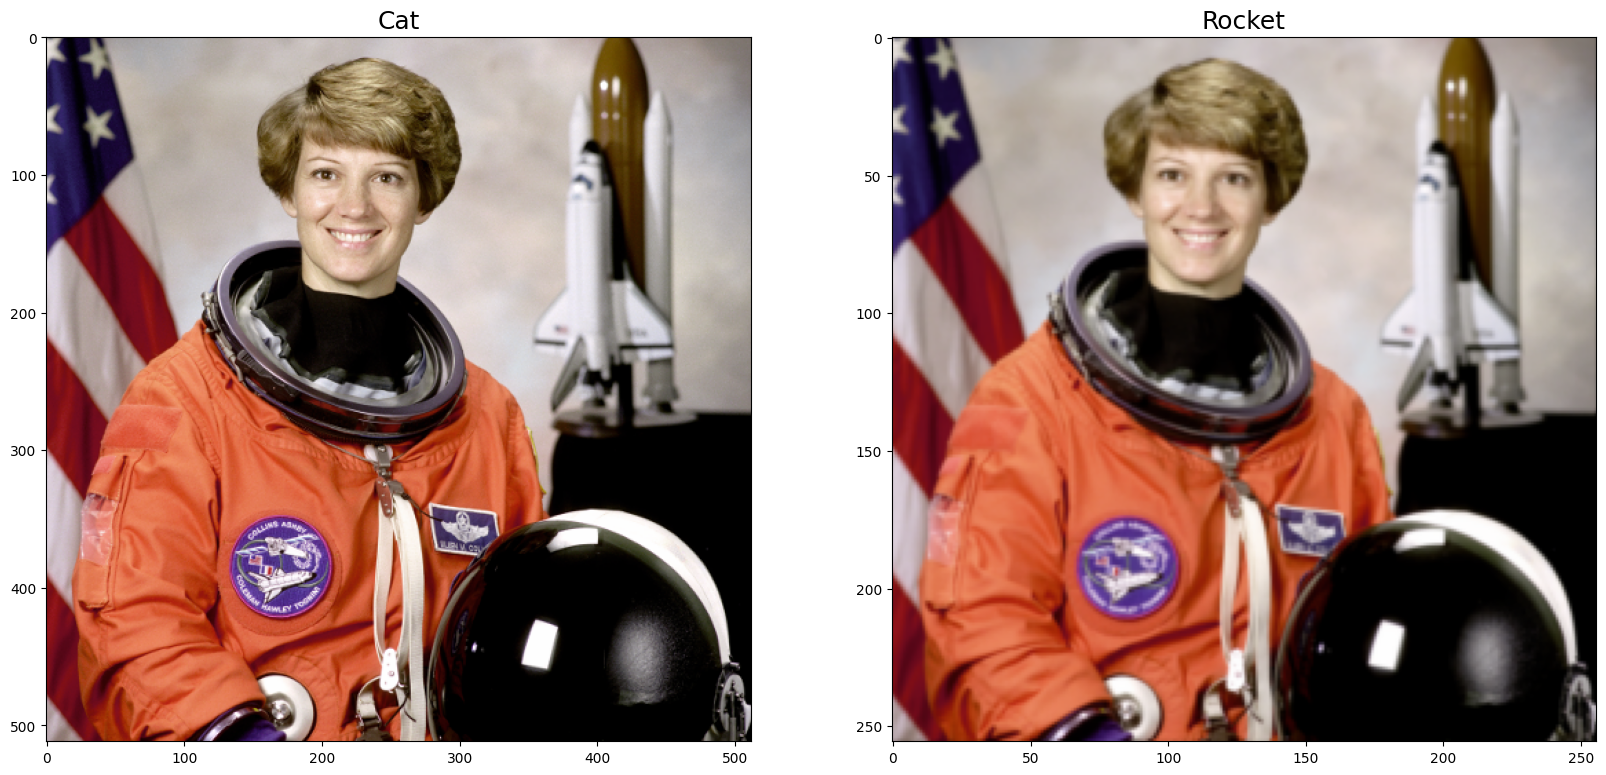

In [76]:
def GREDUCE(I,h):
  padded_I = IPad(I)
  g = np.zeros((I.shape[0]//2, I.shape[1]//2)) if I.ndim == 2 else np.zeros((I.shape[0]//2, I.shape[1]//2, 3))
  for i in range(I.shape[0]//2):
    for j in range(I.shape[1]//2):
      g[i,j] = sum(sum(h * padded_I[(2*(i+1)-2):(2*(i+1)+2)+1, (2*(j+1)-2):(2*(j+1)+2)+1])) if I.ndim == 2 else sum(sum(h[:, :, np.newaxis] * padded_I[(2*(i+1)-2):(2*(i+1)+2)+1, (2*(j+1)-2):(2*(j+1)+2)+1]))
  return g

B = data.astronaut()

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 10)) # (lines, columns, inches)

ax0.imshow(B.astype('uint8'))
ax0.set_title('Cat', fontsize=18)

ax1.imshow(GREDUCE(B,GKernel(0.4)).astype('uint8'))
ax1.set_title('Rocket', fontsize=18)

**GPyramid**

Text(0.5, 1.0, 'Rocket4')

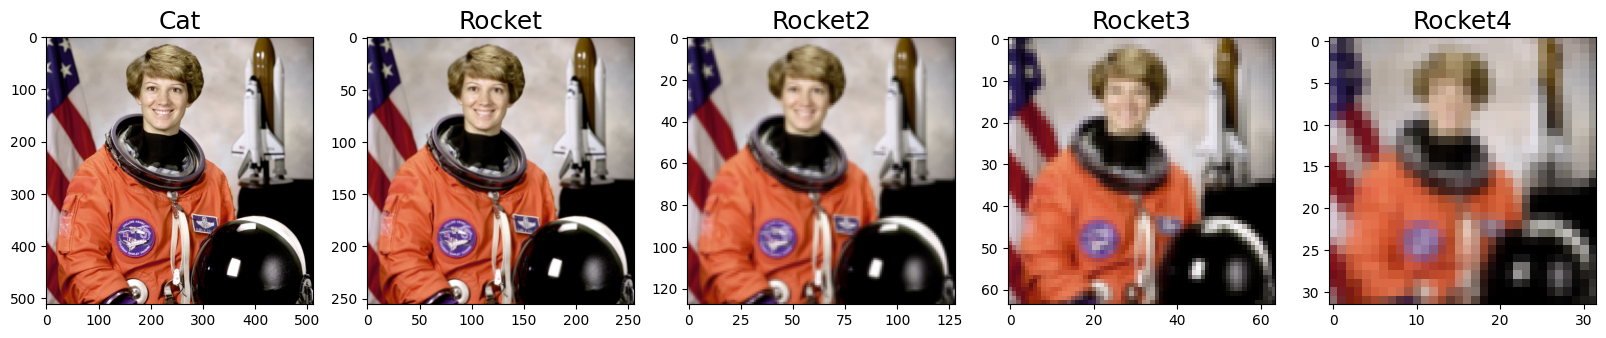

In [77]:
def GPyramid(I, a, depth):
  kernel = GKernel(a)
  gpyr=[]
  gpyr.append(I)
  for i in range(1, depth):
    gpyr.append(GREDUCE(gpyr[i-1], kernel))
  return gpyr

gpyr = GPyramid(B, 0.4, 5)

f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(20, 10)) # (lines, columns, inches)

ax0.imshow(gpyr[0].astype('uint8'))
ax0.set_title('Cat', fontsize=18)

ax1.imshow(gpyr[1].astype('uint8'))
ax1.set_title('Rocket', fontsize=18)

ax2.imshow(gpyr[2].astype('uint8'))
ax2.set_title('Rocket2', fontsize=18)

ax3.imshow(gpyr[3].astype('uint8'))
ax3.set_title('Rocket3', fontsize=18)

ax4.imshow(gpyr[4].astype('uint8'))
ax4.set_title('Rocket4', fontsize=18)

**GEXPAND**

Text(0.5, 1.0, 'Rocket')

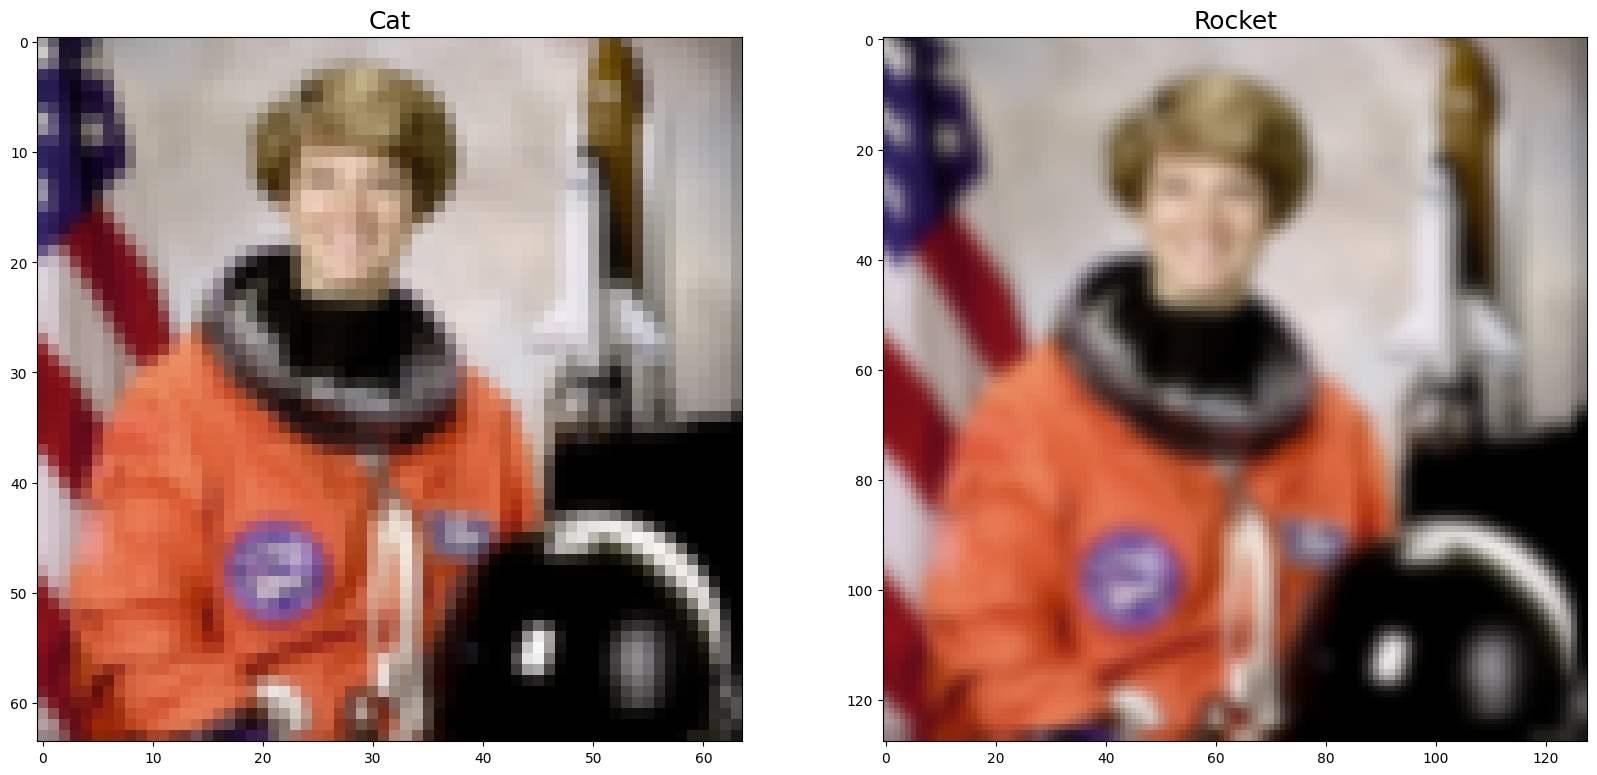

In [78]:
def GEXPAND (I, h):
  padded_I = IPad(I)
  g = np.zeros((I.shape[0]*2, I.shape[1]*2)) if I.ndim == 2 else np.zeros((I.shape[0]*2, I.shape[1]*2, 3))
  for i in range(I.shape[0]*2):
    for j in range(I.shape[1]*2):
      for m in range(-2,3):
        for n in range(-2,3):
          if ((i-m)%2 == 0 and (j-n)%2 == 0):
            g[i,j] += h[m+2, n+2] * padded_I[(i+2-m)//2,(j+2-n)//2] if I.ndim == 2 else h[m+2, n+2, np.newaxis] * padded_I[(i+2-m)//2,(j+2-n)//2]
      g[i,j] *= 4
  return g

gpyr = GPyramid(B, 0.4, 10)

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 10)) # (lines, columns, inches)

ax0.imshow(gpyr[3].astype('uint8'))
ax0.set_title('Cat', fontsize=18)

ax1.imshow(GEXPAND(gpyr[3],GKernel(0.4)).astype('uint8'))
ax1.set_title('Rocket', fontsize=18)

**LPyramid**

Text(0.5, 1.0, 'Rocket4')

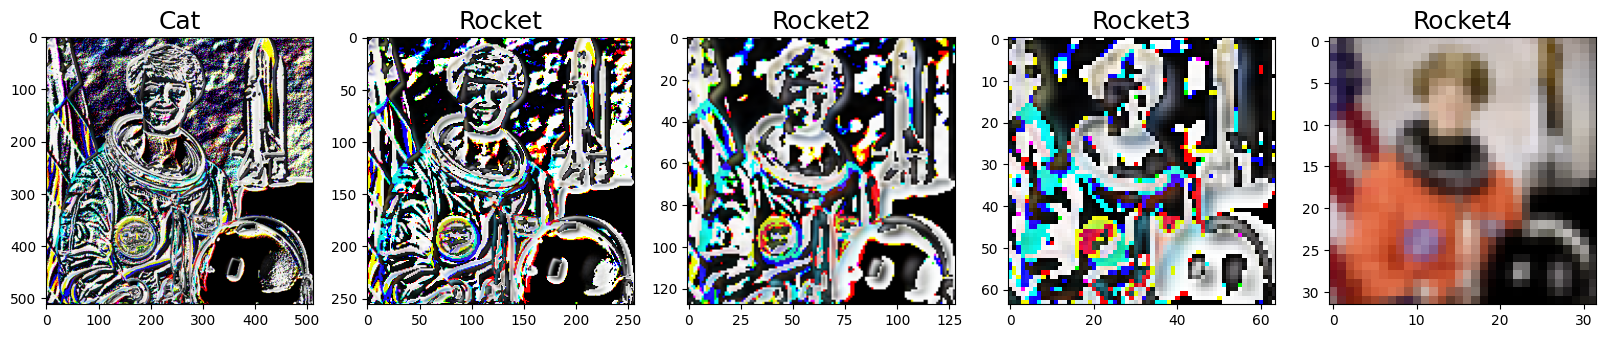

In [79]:
def LPyramid(I, a, depth):
  gPyramid = GPyramid(I, a, depth)
  lPyramid = []
  kernel = GKernel(a)
  for i in range(len(gPyramid)-1):
    lPyramid.append(gPyramid[i] - GEXPAND(gPyramid[i+1], kernel))

  lPyramid.append(gPyramid[-1])
  return lPyramid

lpyr = LPyramid(B, 0.4, 5)

f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(20, 10)) # (lines, columns, inches)

ax0.imshow(lpyr[0].astype('uint8'))
ax0.set_title('Cat', fontsize=18)

ax1.imshow(lpyr[1].astype('uint8'))
ax1.set_title('Rocket', fontsize=18)

ax2.imshow(lpyr[2].astype('uint8'))
ax2.set_title('Rocket2', fontsize=18)

ax3.imshow(lpyr[3].astype('uint8'))
ax3.set_title('Rocket3', fontsize=18)

ax4.imshow(lpyr[4].astype('uint8'))
ax4.set_title('Rocket4', fontsize=18)

**L_Pyramid_Decode**

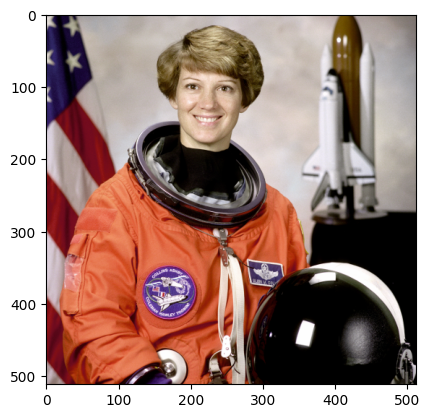

In [80]:
def L_Pyramid_Decode(L,a):
  kernel = GKernel(a)
  g = [L[-1]]
  for i in range(1, len(L)): 
    g.append(L[-1-i] + GEXPAND(g[i-1], kernel))
  return g[-1]

plt.imshow(L_Pyramid_Decode(LPyramid(B,0.4,10),0.4).astype('uint8'))

**L_Quantization**

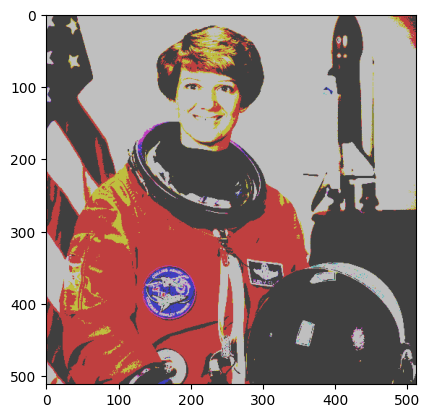

In [81]:
def L_Quantization(I,n):
  if I.ndim == 2:
    min = np.min(I)
    max = np.max(I)
    bin_range = max - min
    bin_size = bin_range / n
  else:
    min, max, bin_size, bin_range = [], [], [], []
    for i in range(3):
      min.append(np.min(I[..., i]))
      max.append(np.max(I[..., i]))
      bin_range.append(max[i]-min[i])
      bin_size.append(bin_range[0]/n)
  quant_I = np.zeros((I.shape[0], I.shape[1])) if I.ndim == 2 else np.zeros((I.shape[0], I.shape[1], 3))
  for i in range(I.shape[0]):
    for j in range(I.shape[1]):
      quant_I[i,j] = min+(math.floor(((I[i][j]-min)/bin_size))*bin_size+bin_size/2) if I.ndim == 2 else [(min[0]+(math.floor(((I[i,j,0]-min[0])/bin_size[0]))*bin_size[0]+bin_size[0]/2)), (min[1]+(math.floor(((I[i,j,1]-min[1])/bin_size[1]))*bin_size[1]+bin_size[1]/2)), (min[2]+(math.floor(((I[i,j,2]-min[2])/bin_size[2]))*bin_size[2]+bin_size[2]/2))]
  return quant_I

plt.imshow(L_Quantization(B, 2).astype('uint8'))